# Análisis inferencial

El objetivo del análisis inferencial, bajo el enfoque clásico, es producir proposiciones probables acerca de los parámetros de una *población* a partir de los análisis de una *muestra*, partiendo del supuesto de que esta muestra representa fielmente a la población.

Los análisis de inferencia más importantes son:
- Estimaciones puntuales: estimaciones de valor esperado de un parámetro estadístico de la población, p.e., la media.
- Intervalos de confianza: estimaciones de los rangos de valores que mejor representan algún parámetro de interés.
- Aceptación o rechazo de una hipótesis.

Antes estas inferencias se hacian basadas en modelos teóricos ideales. Ahora, que los computadores se usan de manera masiva, se puede hacer inferencia basados en métodos más intensivos computacionalmente pero más realistas, como las técnicas de remuestreo, las cadenas de Markov, y los métodos de Monte Carlo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

In [38]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original", sep='\s+', header=None, na_values=['?'],
                 names=['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car_name'])
df = df[df['mpg'].notnull()]
df['horsepower'].fillna(value=df.horsepower.mean(), inplace=True)
df.set_index('car_name', inplace=True)
df['origin'] = df['origin']==1
df.origin = df.origin.map({True: 'USA', False: 'Non USA'})
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
car_name,,,,,,,,
chevrolet chevelle malibu,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,USA
buick skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,USA
plymouth satellite,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,USA
amc rebel sst,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,USA
ford torino,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,USA


In [39]:
df.groupby('origin').agg(['mean', 'std'])

mpg           cylinders           displacement             \
              mean       std      mean       std         mean        std   
origin                                                                     
Non USA  29.248322  6.501337  4.127517  0.548814   105.731544  23.028957   
USA      20.083534  6.402892  6.248996  1.661425   245.901606  98.501839   

         horsepower                  weight             acceleration  \
               mean        std         mean         std         mean   
origin                                                                 
Non USA   80.496233  18.955105  2316.161074  419.920746    16.461074   
USA      118.814769  39.617323  3361.931727  794.792506    15.033735   

                  model_year            
              std       mean       std  
origin                                  
Non USA  2.536483  76.677852  3.647043  
USA      2.751112  75.610442  3.677094

In [40]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin'],
      dtype='object')

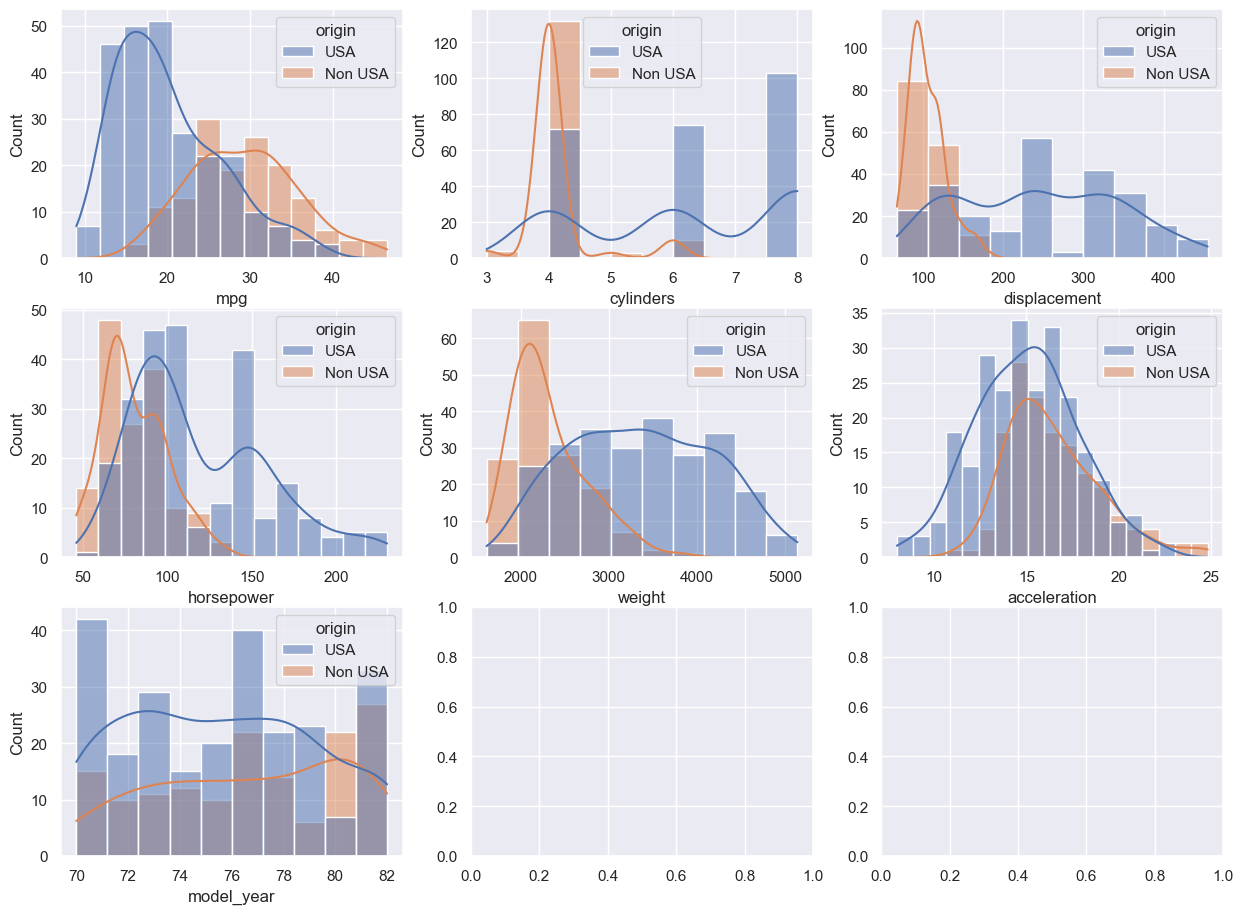

In [43]:
fig, axs = plt.subplots(3, 3, figsize=(15, 11))
for i, col in enumerate(df.columns[:-1]):
    sns.histplot(data=df, x=col, hue='origin', kde=True, ax=axs[i//3, i%3])

## Estimaciones puntuales

En este caso el tipo de pregunta que se desea responder con el análisis es: ¿Cuál es el valor esperado de la parámetro de una variable, y con que incertidumbre o error?

Podría pensarse que el parámetro de la muestra es el valor esperado, pero esto no es necesariamente cierto.

Veamos por ejemplo la media del número de citaciones en 3 años.

In [45]:
df.groupby('origin')['mpg'].mean()

origin
Non USA    29.248322
USA        20.083534
Name: mpg, dtype: float64

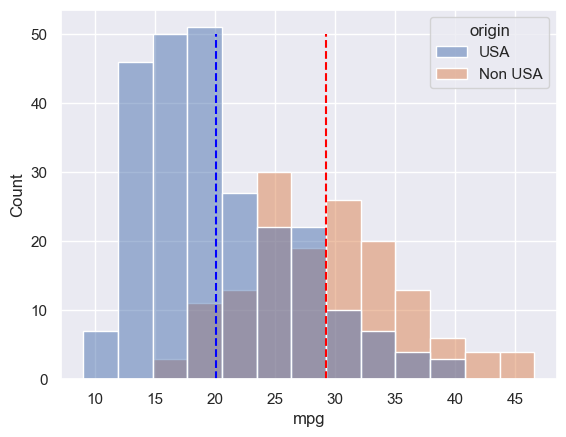

In [65]:
sns.histplot(data=df, x='mpg', hue='origin')
plt.vlines(df[df['origin']=='USA']['mpg'].mean(), 0, 50, colors='blue', linestyles='dashed')
plt.vlines(df[df['origin']=='Non USA']['mpg'].mean(), 0, 50, colors='red', linestyles='dashed');

En realidad, el valor esperado de la media debería calcularse promediando las medias de muchas muestras aleatorias de la misma población. La incertidumbre sería en este caso la desviación estándar de ese conjunto de medias. Esta medida ser conoce como *error estándar*, y es diferente a la desviación estándar de la muestra.

El problema es que casi nunca es posible tener muchas muestras aleatorias de una población, casi siempre tenemos solo una.

De forma tradicional, el error estándar se calcula así:

\begin{equation}
SE =  \frac{\sigma_x}{\sqrt{n}}
\end{equation}

donde $\sigma_x$ es la desviación estándar de la muestra disponible y $n$ es el número de observaciones de la muestra.

In [49]:
df.groupby('origin')['mpg'].agg(lambda x: np.std(x, ddof=1)/np.sqrt(len(x)))


origin
Non USA    0.532610
USA        0.405767
Name: mpg, dtype: float64

Dado que lo ideal sería tener muchas muestras, se han creado varias técnicas de remuestreo para generar múltiples meustras a partir de la muestra original. Un conjunto de técnicas muy usadas son las de *bootstrap*, que son técnicas de *remuestreo* con reemplazo. 

In [61]:
from scipy.stats import bootstrap
bs_usa = bootstrap(data=np.array(df[df['origin']=='USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.mean)
bs_non_usa = bootstrap(data=np.array(df[df['origin']=='Non USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.mean)
df_mpg_by_origin = pd.DataFrame(data=[['USA', bs_usa.bootstrap_distribution.mean(), bs_usa.bootstrap_distribution.std()],
                                      ['Non USA', bs_non_usa.bootstrap_distribution.mean(), bs_non_usa.bootstrap_distribution.std()]],
                                      columns=['origin','mean','standard_error'])
df_mpg_by_origin

,origin,mean,standard_error
0,USA,20.097991,0.404137
1,Non USA,29.252660,0.529684


Usualmente, la distribución muestral de los parámetros (la media, la mediana, la desviación estándar) de una población tiende a ser normal, así la distribución de la población no sea normal.

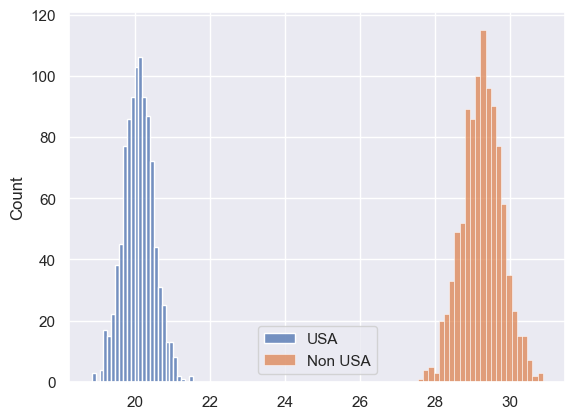

In [64]:
sns.histplot(bs_usa.bootstrap_distribution, label='USA')
sns.histplot(bs_non_usa.bootstrap_distribution, label='Non USA')
plt.legend();

Con el método de bootstrap es posible calcular los valores esperados de otros medidas diferentes a la media. Con el método clásico no es posible.

In [69]:
from scipy.stats import bootstrap
bs_usa = bootstrap(data=np.array(df[df['origin']=='USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.median)
bs_non_usa = bootstrap(data=np.array(df[df['origin']=='Non USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.median)
df_mpg_by_origin = pd.DataFrame(data=[['USA', bs_usa.bootstrap_distribution.mean(), bs_usa.bootstrap_distribution.std()],
                                      ['Non USA', bs_non_usa.bootstrap_distribution.mean(), bs_non_usa.bootstrap_distribution.std()]],
                                      columns=['origin','mean','standard_error'])
df_mpg_by_origin

c:\Users\yonki\anaconda3\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\yonki\anaconda3\Lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


,origin,mean,standard_error
0,USA,18.6184,0.504045
1,Non USA,29.1224,0.881883


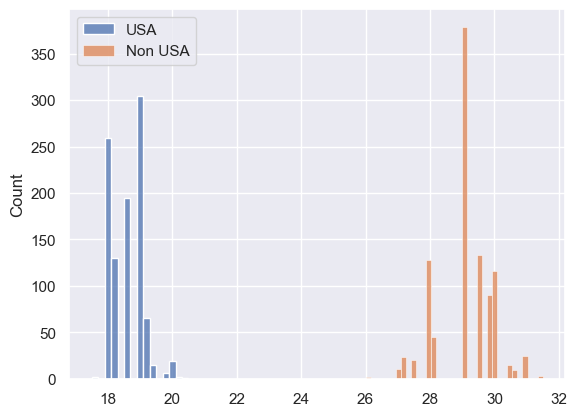

In [67]:
sns.histplot(bs_usa.bootstrap_distribution, label='USA')
sns.histplot(bs_non_usa.bootstrap_distribution, label='Non USA')
plt.legend();

## Intervalos de confianza

La estimación puntual da un único valor plausible para un parámetro. Sin embargo, como se ha visto, esta estimación no es perfecta, y tiene algún error, que es expresado en el error estándar como medida de variabilidad.

El siguiente paso es dar un *rango de valores plausibles* para el parámetro. Este rango se llama *intervalo de confianza*.

El método clásico solo funciona para distribuciones normales de la muestra. Asumiendo que esto es cierto, el intervalo de confianza del 95% se define como:

\begin{equation}
95\% CI = [\theta - 1.96*SE, \theta + 1.96*SE]
\end{equation}

In [71]:
# Calcular intervalos de confianza para la variable mpg agrupada por origin
df.groupby('origin')['mpg'].agg(lambda x: [np.mean(x) - 1.96*np.std(x, ddof=1)/np.sqrt(len(x)),np.mean(x) + 1.96*np.std(x, ddof=1)/np.sqrt(len(x))])

origin
Non USA    [28.204406047275505, 30.292238248026507]
USA        [19.288231219510376, 20.878837053581993]
Name: mpg, dtype: object

Con bootstrap no es necesario que la distribución muestral sea normal. El $CI$ se calcularía encontrando los percentiles 2.5 y 97.5 de la distribución muestral del parámetro, aunque el método "bootstrap" de SciPy hace eso por nosotros.

In [74]:
bs_usa = bootstrap(data=np.array(df[df['origin']=='USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.mean)
bs_non_usa = bootstrap(data=np.array(df[df['origin']=='Non USA']['mpg']).reshape(1,-1), n_resamples=1000, statistic=np.mean)
print('Intervalo de confianza del 95% para la media de mpg con origen Non USA: [', bs_non_usa.confidence_interval[0],',', bs_non_usa.confidence_interval[1], ']')
print('Intervalo de confianza del 95% para la media de mpg con origen USA: [', bs_usa.confidence_interval[0],',', bs_usa.confidence_interval[1], ']')

Intervalo de confianza del 95% para la media de mpg con origen Non USA: [ 28.179060651667882 , 30.224044633531214 ]
Intervalo de confianza del 95% para la media de mpg con origen USA: [ 19.333799122672254 , 20.907060395527395 ]


En Seaborn existe el método **poinplot**, que permite graficar las estimaciones puntuales y los intervalos de confianza.

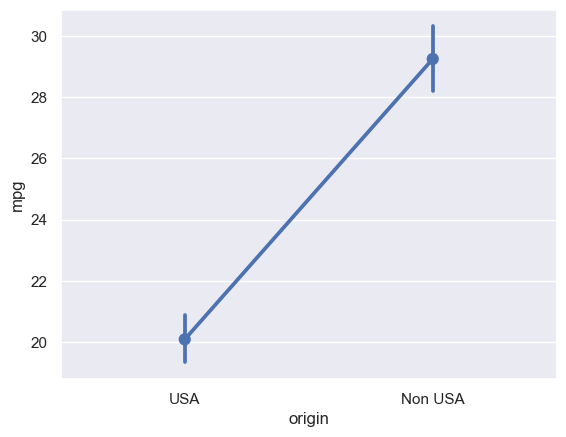

In [77]:
sns.pointplot(data=df, x='origin', y='mpg', errorbar=('ci', 95));

¿Qué es el intervalo de confianza?

La interpretación del *95\% CI* no es tan evidente, y suele mal interpretarse como que existe un $95\%$ de probabilidad de que el verdadero valor de un parámetro esté en ese intervalo. La interpretación correcta es que si se repitiera muchísimas veces el muestreo aleatorio de una población, en las mismas condiciones que se hizo con la muestra que tenemos, el $95\%$ de las veces el $95\% CI$ contendría el verdadero valor del parámetro.

Para un analista de datos, el $95\% CI$ es simplemente una medida de cuan variable puede ser un resultado. No nos preocupamos mucho por la interpretación formal del $95\% CI$.

En general, si la muestra es pequeña el $95\% CI$ tenderá a ser más grande, lo que es un indicador de mayor incertidumbre sobre el resultado.

# Pruebas de hipótesis

En general, las pruebas de hipótesis son comparaciones entre algún parámetro estadístico de 2 o más muestras, para saber si perteneces a la misma población (esto se llama hipótesis nula $H_0$) o pertenecen a poblaciones diferentes (esto se llama hipótesis alternativa $H_1$). La pruebas de hipótesis se basan en el concepto de *significancia estadística*, que es una forma de decir que las diferencias entre algún parámetro estadístico de 2 muestras es lo suficientemente grande para que no sea producto del azar.

Existen varias técnicas para hacer pruebas estadísticas. Vamos a empezar por la más tradicional que es la prueba *t* de Student.

## La prueba $t$ de Student

La prueba $t$ de Student, también conocida simplemente como prueba $t$, es una herramienta estadística utilizada para evaluar si la diferencia entre las medias de dos grupos es estadísticamente significativa. 

Esta prueba se debería aplicar únicamente si la muestra o muestras siguen una **distribución normal**.

Existen 3 tipos de pruebas t de Student:
- Prueba $t$ para una muestra: Analiza sí la media de una muestra es diferente, mayor o menor de algún valor $\mu$.
- Prueba $t$ para dos muestras independientes: Estudia si la diferencia entre las medias de dos muestras independientes es diferente, mayor o menor de 0.
- Prueba $t$ para dos muestras pareadas: Investiga si la diferencia de las medias de una muestra evaluada dos veces es diferente, mayor o menor de 0.

Para el caso de dos muestras independientes la Fórmula del estadístico de prueba es:

$$ t = \frac{\bar X_1 - \bar X_2}{\sqrt{\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}}}$$

Donde:

- $t$ es el estadístico de la prueba.
- $\bar X_1$ es la media de la muestra 1.
- $s_1$ es la desviación estándar de la muestra 1.
- $n_1$ es el tamaño de la muestra 1.

Si se quiere evaluar si la media de la muestra 1 es mayor a la media de la muestra 2, la prueba es de **cola derecha**. En este caso se evalúa la probabilidad de que el valor *t* obtenido sea menor a cierto valor $\alpha$, lo que equivaldría a evaluar sí este valor $t$ está más allá del percentil $100(1-\alpha)$ en la distribución del estadístico de prueba. 

Si se quiere evaluar si la media de la muestra 1 es menor a la media de la muestra 2, la prueba es de **cola izquierda**. En este caso se evalúa la probabilidad de que el valor *t* obtenido sea menor a cierto valor $\alpha$, lo que equivaldría a evaluar sí este valor $t$ está más acá del percentil $100*\alpha$ en la distribución del estadístico de prueba. 

Por último, si se quiere evaluar si la diferencia de la media entre las muestras es diferente de 0, sin importar cual de las 2 medias es mayor, entonces la prueba es de **dos colas** o  **bilateral**. En este caso se evalúa la probabilidad de que el valor $t$ obtenido sea menor a $\frac{\alpha}{2}$ o  mayor a $1-\frac{\alpha}{2}$.

La probabilidad calculada se conoce como valor $p$. Usualmente $\alpha=0.05$, y en este caso si el valor $p$ es menor a $0.05$ se infiere que existen diferencias estadísticamente significativas entre las medias de las muestras, que en lenguaje estadística es *rechazar la hipótesis nula*, y sí el valor $p$ es mayor a $0.05$ no se puede inferir si las diferencias son estadísticamente significativas o no, que en lenguaje estadístico es aceptar la hipótesis nula.

La prueba $t$ para muestras independientes se pude hacer con el método **ttest_ind** de Scipy.

Vamos a probar si existen diferencias significativas en la variable 'acceleration' por niveles de la variable 'origin'.

<Axes: xlabel='origin', ylabel='acceleration'>

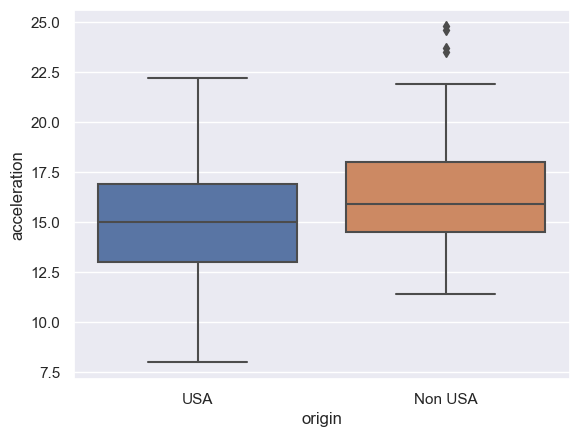

In [112]:
sns.boxplot(data=df, x='origin', y='acceleration')

En este caso el gráfico de pointplot y las estimaciones puntuales de medias nos muestran que la media del grupo 'Non USA' es mayor a la del grupo 'USA' por lo que deberíamos hacer una prueba $t$ de cola izquierda.

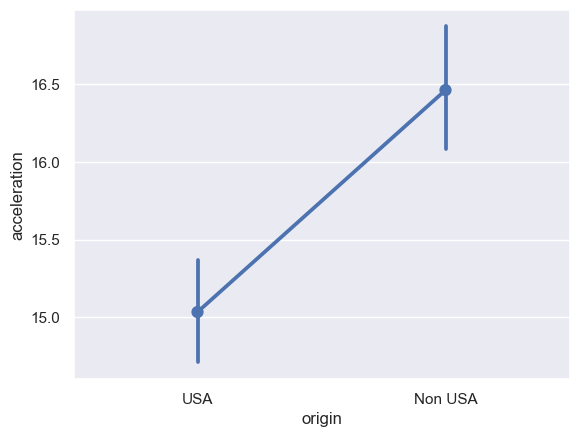

In [105]:
sns.pointplot(data=df, x='origin', y='acceleration', errorbar=('ci', 95));

Antes de hacer la prueba deberíamos verificar si se cumple con el supuesto de que las 2 muestras son normales, y también deberían evaluarse si las 2 muestras tienen varianzas iguales (cumplen con el criterio de homocedasticidad), o por lo menos similares.

La prueba de normalidad se hace con el método de Shapiro-Wilk, si la muestra es pequeña (en teoría menor a 50, aunque con muestras algo más grnades funciona aún bien), y con el Kolgomorov-Smirnov, si es grande. Ambos métodos están implementados en Scipy.

In [106]:
import scipy
from scipy.stats import kstest
ks_usa = kstest(df[df['origin']=='USA']['acceleration'], cdf=scipy.stats.norm.cdf)
ks_non_usa = kstest(df[df['origin']=='Non USA']['acceleration'], cdf=scipy.stats.norm.cdf)
print(f'p-value para muestra USA: {ks_usa.pvalue:.3f}')
print(f'p-value para muestra Non USA: {ks_non_usa.pvalue:.3f}')

p-value para muestra USA: 0.000
p-value para muestra Non USA: 0.000


Los resultados de la prueba indican que las muestras **no tienen distribución normal**, as´que no deberíamos aplicar una prueba $t$.

Ahora vamos a probar si las 2 muestras tienen igual varianza.

In [107]:
# Hacer test de Levene a mpg por niveles de origin
from scipy.stats import levene
p_levene = levene(df[df['origin']=='USA']['acceleration'], df[df['origin']=='Non USA']['acceleration']).pvalue
print(f'p-value para test de igual varianza: {p_levene:.3f}')

p-value para test de igual varianza: 0.151


Los resultados de la prueba indican que las 2 muestras tienen igual varianza.

A pesar del resultado del test de Kolgomorov-Smirnov vamos a hacer la prueba $t$.

In [108]:
from scipy.stats import ttest_ind
p_ttest = ttest_ind(df[df['origin']=='USA']['acceleration'], df[df['origin']=='Non USA']['acceleration'], equal_var=True, alternative='less').pvalue
print(f'p-value para prueba t: {p_ttest:.3f}')

p-value para prueba t: 0.000


Este resultado nos permite inferir que la media de la muestra "Non USA" es mayor a la media de la muestra "USA", y que la diferncia entre estas medias es estadísticamente significativa, es decir, que no puede deberse al azar, así que se rechaza la hipótesis nula.

Como en este caso no se cumplía con el supuesto de normalidad de las muestras, no debió haberse hecho la prueba $t$. En lugar de eso debió haberse realizado una prueba de hipótesis no paramétrica, como la de **Mann-Whitney U rank**, o por permutaciones. 

Vamos a usar el método de permutaciones. El paso a paso de este método es el siguiente:
1. Se calcula la diferencia entre las medias de las 2 muestras.
2. Se mezclan las 2 muestras.
3. Se generan 2 muestras nuevas seleccionando observaciones aleatoriamente.
4. Se calcula la diferencia entre las medias de las muestras generadas.
5. Los pasos 3 y 4 se repiten muchas veces, por lo menos 10000 veces. Esto hace que se genere una distribución de la diferencia de las medias de las muestras.
6. Se calcula en que percentil quedó la diferencia de las medias de las muestras originales. Sí la prueba es de cola izquierda y esta diferencia queda por debajo del percentil 5 se rechaza la hipótesis nula. Sí la prueba es bilateral y esta diferencia queda por encima del percentil 97.5 o por debajo del percentil 2.5 se rechaza la hipótesis nula.

En Scipy esta prueba por permutaciones se hace usando el parámetro **permutations** del mismo método.

In [109]:
from scipy.stats import ttest_ind
p_ttest = ttest_ind(df[df['origin']=='USA']['acceleration'], df[df['origin']=='Non USA']['acceleration'], equal_var=True, alternative='less', permutations=10000).pvalue
print(f'p-value para prueba t: {p_ttest:.3f}')

p-value para prueba t: 0.000


## ¿Cómo se interpreta el valor-$p$?

El valor $p$ tiende a interpretarse como la probabilidad de que los resultados encontrados (la diferencia entre medias) se deban al azar (a la aleatoriedad de las muestras). No es así, porque el valor-$p$ es $P(datos|H)$, y no $P(H|datos)$. Es decir, en últimas **no tenemos certeza de que tan probables son las hipótesis**. A pesar de todo, un valor-$p$ muy pequeño no significa que la hipótesis alternativa sea cierta.

Más allá de las controversias científicas, en análisis de datos el valor-$p$ es una medida de que tan probable es una hipótesis con respecto a la otra, pero esta interpretación debería estar acompañada de otras medidas como los intervalos de confianza y el tamaño del efecto.